# Student: Arailym Kaiyrova
# Walmart Sales Forecasting
**Abstract:**

One of kaggle's competitions was about predicting future sales for Walmart. There were given historical data on weekly sales for 45 different stores, each having about 80 departments, and there were were given information about weekly sales for each of these department for the period from February 2010 to October 2012. Furthermore, there were given information about size, and type of the stores, the presence of the special holiday in a given week, and the presence of markdown events supported by Walmart throughout the choosen period. Also, as an additional data there were given information about fuel prices, temperature outside, consumer price index (CPI), and unemployment in the country. 

The purpose of this project was to apply various regression models on the data, to identify the best model by tuning their hyperparameters, and according to the highest cross validation score mean.

For this project the following models were tested:

1. Linear Regression
2, Bayesian Ridge
3. Decision Tree Regressor
4. Gradient Boosting Regressor
5. Random Forest Regressor




## Initial step was taken was importing the library packeges, and reading the csv files

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML

import sklearn
#models
from sklearn import datasets, linear_model
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import LeaveOneOut
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve


from datetime import datetime
from datetime import timedelta


#Reading Data
train=pd.read_csv('/Users/arailymkaiyrova/Desktop/Walmart/train.csv')
features=pd.read_csv('/Users/arailymkaiyrova/Desktop/Walmart/features.csv')
stores=pd.read_csv('/Users/arailymkaiyrova/Desktop/Walmart/stores.csv')

## Merging the files
Since we have given three different documents with different column sizes, it was necessary to combine them

In [45]:
stores_features = pd.merge(stores, features, on=['Store'], how = 'left').fillna(0)
walmart_data = pd.merge(train, stores_features, on=['Store','Date','IsHoliday'], how = 'left').fillna(0)
walmart_data.head().transpose()

,0,1,2,3,4
Store,1,1,1,1,1
Dept,1,1,1,1,1
Date,2010-02-05,2010-02-12,2010-02-19,2010-02-26,2010-03-05
Weekly_Sales,24924.5,46039.5,41595.6,19403.5,21827.9
IsHoliday,False,True,False,False,False
Type,A,A,A,A,A
Size,151315,151315,151315,151315,151315
Temperature,42.31,38.51,39.93,46.63,46.5
Fuel_Price,2.572,2.548,2.514,2.561,2.625
MarkDown1,0,0,0,0,0


## Constructing correlation table
Since we have several features, I decided initially to construct a correlation table to identify the key features

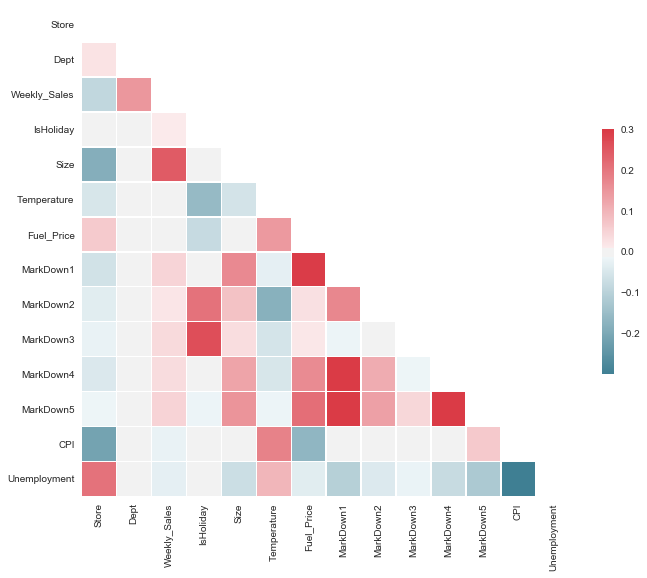

In [46]:
sns.set(style="white")
corr = walmart_data.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Data adjustments, and identifying new possible features

Since holidays, markdown events happens in particular period of the year, and our target value is calculated weekly, I find it important to include the week of the year. Then, next step is to convert date to week number.

In [47]:
walmart_data['Date'] = pd.to_datetime(walmart_data['Date'])
walmart_data['Year'] = walmart_data['Date'].dt.year
walmart_data['Week'] = walmart_data['Date'].dt.week
walmart_data.drop(['Year'], axis=1, inplace=True)
walmart_data = pd.get_dummies(walmart_data)

Text(0.5,0,'Week')

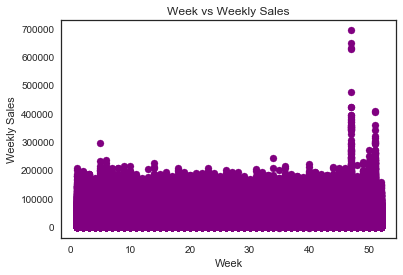

In [48]:
plt.scatter(walmart_data['Week'], walmart_data['Weekly_Sales'], color = "purple")
plt.title("Week vs Weekly Sales")
plt.ylabel("Weekly Sales")                
plt.xlabel("Week")

In [49]:
walmart_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Store,421570.0,22.200546,12.785297,1.000,11.000000,22.00000,33.000000,45.000000
Dept,421570.0,44.260317,30.492054,1.000,18.000000,37.00000,74.000000,99.000000
Weekly_Sales,421570.0,15981.258123,22711.183519,-4988.940,2079.650000,7612.03000,20205.852500,693099.360000
Size,421570.0,136727.915739,60980.583328,34875.000,93638.000000,140167.00000,202505.000000,219622.000000
Temperature,421570.0,60.090059,18.447931,-2.060,46.680000,62.09000,74.280000,100.140000
Fuel_Price,421570.0,3.361027,0.458515,2.472,2.933000,3.45200,3.738000,4.468000
MarkDown1,421570.0,2590.074819,6052.385934,0.000,0.000000,0.00000,2809.050000,88646.760000
MarkDown2,421570.0,879.974298,5084.538801,-265.760,0.000000,0.00000,2.200000,104519.540000
MarkDown3,421570.0,468.087665,5528.873453,-29.100,0.000000,0.00000,4.540000,141630.610000
MarkDown4,421570.0,1083.132268,3894.529945,0.000,0.000000,0.00000,425.290000,67474.850000


In [50]:
walmart_data.loc[walmart_data['Weekly_Sales'] >220000,"Date"].value_counts()

2011-11-25    26
2010-12-24    25
2010-11-26    25
2011-12-23    14
2010-12-17     3
2010-02-05     2
2010-12-10     1
2012-02-10     1
2011-10-07     1
2011-02-11     1
2011-08-26     1
2012-04-06     1
2011-12-09     1
Name: Date, dtype: int64

In [51]:
walmart_data['Black_Friday'] = np.where((walmart_data['Date']==datetime(2010, 11, 26).date()) | (walmart_data['Date']==datetime(2011, 11, 25).date()), 1, 0)
walmart_data['Christmas'] = np.where((walmart_data['Date']==datetime(2010, 12, 24).date()) | (walmart_data['Date']==datetime(2011, 12, 23).date()), 1, 0)
Black_Friday_dummies = pd.get_dummies(walmart_data['Black_Friday'] )
Christmas_dummies = pd.get_dummies(walmart_data['Christmas'] )
walmart_data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,MarkDown4,MarkDown5,CPI,Unemployment,Week,Type_A,Type_B,Type_C,Black_Friday,Christmas
0,1,1,2010-02-05,24924.50,False,151315,42.31,2.572,0.0,0.0,...,0.0,0.0,211.096358,8.106,5,1,0,0,0,0
1,1,1,2010-02-12,46039.49,True,151315,38.51,2.548,0.0,0.0,...,0.0,0.0,211.242170,8.106,6,1,0,0,0,0
2,1,1,2010-02-19,41595.55,False,151315,39.93,2.514,0.0,0.0,...,0.0,0.0,211.289143,8.106,7,1,0,0,0,0
3,1,1,2010-02-26,19403.54,False,151315,46.63,2.561,0.0,0.0,...,0.0,0.0,211.319643,8.106,8,1,0,0,0,0
4,1,1,2010-03-05,21827.90,False,151315,46.50,2.625,0.0,0.0,...,0.0,0.0,211.350143,8.106,9,1,0,0,0,0


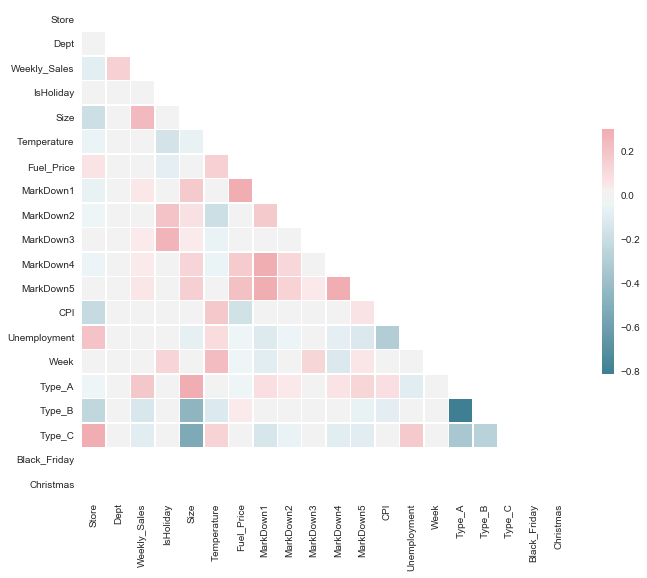

In [52]:
sns.set(style="white")
corr = walmart_data.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Model Selection

### Linear Regression, Bayesian Ridge

The next important step was select the most efficient model for prediction. I have tried less complex models such as linear regression, lasso, bayesian ridge. They all have shown a very low training accuracy score.Learning curves for some of them are shown below


In [21]:
y = targets = labels = walmart_data["Weekly_Sales"].values

columns = ["Store", "Dept", "Week", "Black_Friday", "Christmas", "IsHoliday", "CPI", "Unemployment","Size", "Temperature", "Fuel_Price", "MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5", "Type_A", "Type_B", "Type_C"]
features = walmart_data[list(columns)].values
features
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=1)

In [15]:
lin_r = LinearRegression()
lin_r.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [33]:
bay_reg = BayesianRidge(compute_score=True)
bay_reg.fit(X_train, y_train)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=True, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)

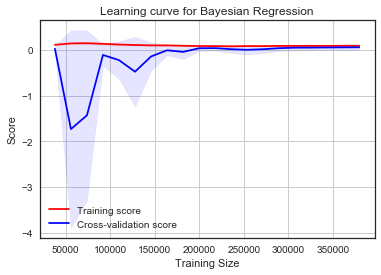

In [34]:
train_size, train_score, test_score = learning_curve(bay_reg, features, y, cv=10, n_jobs=2, train_sizes=np.linspace(.1, 1.0, 20))

train_mean = np.mean(train_score, axis=1)
train_std  = np.std(train_score, axis=1)
test_mean  = np.mean(test_score, axis=1)
test_std   = np.std(test_score, axis=1)

plt.fill_between(train_size, train_mean-train_std, train_mean+train_std, alpha=0.1, color="r")
plt.fill_between(train_size, test_mean-test_std, test_mean+test_std, alpha=0.1, color="b")

plt.plot(train_size, train_mean, color="r",label="Training score")
plt.plot(train_size, test_mean, color="b",label="Cross-validation score")
         
plt.title("Learning curve for Bayesian Regression")
plt.ylabel("Score")                
plt.xlabel("Training Size")
plt.grid()
plt.legend(loc="best")

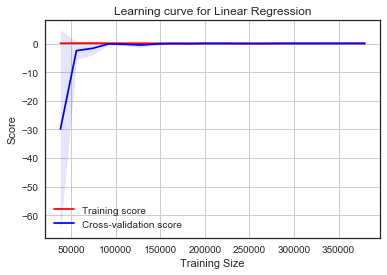

In [16]:
train_size, train_score, test_score = learning_curve(lin_r, features, y, cv=10, n_jobs=2, train_sizes=np.linspace(.1, 1.0, 20))

train_mean = np.mean(train_score, axis=1)
train_std  = np.std(train_score, axis=1)
test_mean  = np.mean(test_score, axis=1)
test_std   = np.std(test_score, axis=1)

plt.fill_between(train_size, train_mean-train_std, train_mean+train_std, alpha=0.1, color="r")
plt.fill_between(train_size, test_mean-test_std, test_mean+test_std, alpha=0.1, color="b")

plt.plot(train_size, train_mean, color="r",label="Training score")
plt.plot(train_size, test_mean, color="b",label="Cross-validation score")
         
plt.title("Learning curve for Linear Regression")
plt.ylabel("Score")                
plt.xlabel("Training Size")
plt.grid()
plt.legend(loc="best")

### Desicion Tree

Due to the low accuracy score, it was necessary to try more complex models, and I started from Decision Tree Regressor. Model fitted well with training data, but on a unseen data is cross validation score showed around 50-55%. By increasing training size, and tuning 'max_depth' parameter, validation score can be maximized up to 60 percent.

In [39]:
regressor = DecisionTreeRegressor(max_depth=50, random_state=0)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=50, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

Learnig Curve For Decision Tree Regressor

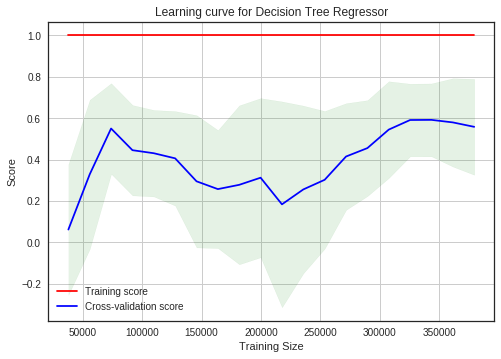

In [47]:
train_size, train_score, test_score = learning_curve(regressor, features, y, cv=10, n_jobs=2, train_sizes=np.linspace(.1, 1.0, 20))

train_mean = np.mean(train_score, axis=1)
train_std  = np.std(train_score, axis=1)
test_mean  = np.mean(test_score, axis=1)
test_std   = np.std(test_score, axis=1)

plt.fill_between(train_size, train_mean-train_std, train_mean+train_std, alpha=0.1, color="r")
plt.fill_between(train_size, test_mean-test_std, test_mean+test_std, alpha=0.1, color="g")

plt.plot(train_size, train_mean, color="r",label="Training score")
plt.plot(train_size, test_mean, color="b",label="Cross-validation score")
         
plt.title("Learning curve for Decision Tree Regressor")
plt.ylabel("Score")                
plt.xlabel("Training Size")
plt.grid()
plt.legend(loc="best")

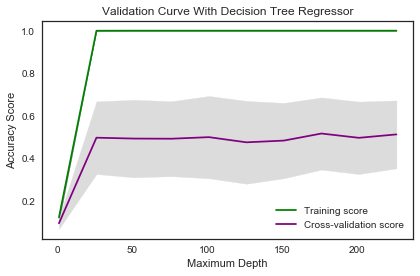

In [43]:
param = [10, 30, 70]

train_scores, test_scores = validation_curve(DecisionTreeRegressor(), 
                                             features, 
                                             y, 
                                             param_name="max_depth",
                                             scoring = "r2",
                                             param_range=param_range,
                                             cv=3, 
                                             n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, label="Training score", color="green")
plt.plot(param_range, test_mean, label="Cross-validation score", color="purple")

plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

plt.title("Validation Curve With Decision Tree Regressor")
plt.xlabel("Maximum Depth")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")

In [40]:
regressor.score(X_test, y_test)

0.9585604990504689

### Gradient Boosting

Next considered model is Gradient Boosting Regressor. The model is known as the combination of weak estimators which makes them a strong model together. The higher the number of estimators used, higher the validation score. From the validation curve below it can be seen that by maximizing the number of trees, score can be incresed intil 65 percent. Also, in learning curve, as the training size increases, the validation score also increases. However, training score decreases, which means that the model is underfitting.

In [44]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

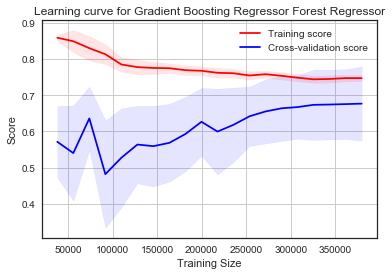

In [14]:
train_size, train_score, test_score = learning_curve(gbr, features, y, cv=10, n_jobs=2, train_sizes=np.linspace(.1, 1.0, 20))

train_mean = np.mean(train_score, axis=1)
train_std  = np.std(train_score, axis=1)
test_mean  = np.mean(test_score, axis=1)
test_std   = np.std(test_score, axis=1)

plt.fill_between(train_size, train_mean-train_std, train_mean+train_std, alpha=0.1, color="r")
plt.fill_between(train_size, test_mean-test_std, test_mean+test_std, alpha=0.1, color="b")

plt.plot(train_size, train_mean, color="r",label="Training score")
plt.plot(train_size, test_mean, color="b",label="Cross-validation score")
         
plt.title("Learning curve for Gradient Boosting Regressor Forest Regressor")
plt.ylabel("Score")                
plt.xlabel("Training Size")
plt.grid()
plt.legend(loc="best")

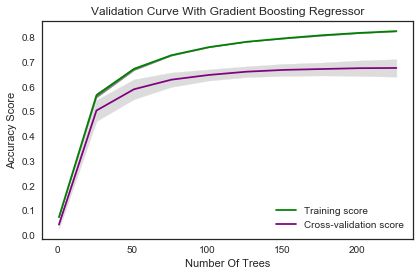

In [45]:
param = [100, 500, 1000, 1500]
train_scores, test_scores = validation_curve(gbr, 
                                             features, 
                                             y, 
                                             param_name="n_estimators",
                                             scoring = "r2",
                                             param_range=param_range,
                                             cv=3, 
                                             n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, label="Training score", color="green")
plt.plot(param_range, test_mean, label="Cross-validation score", color="purple")


plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

plt.title("Validation Curve With Gradient Boosting Regressor")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

In [0]:
gbr.score(X_test, y_test)

0.7512941634068129

### Random Forest Regressor

Random Forest Regressor is a collection of Desicion Tree models, that's why, its accuracy also depends on number of trees used. However, validation curve for random forest shows that number of tree does not affect the validation scoreafter it reaches 25, which shows about 62 percent accuracy. Validation score can be maximized by increasing the trining size until approximately 67 percent.

In [71]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

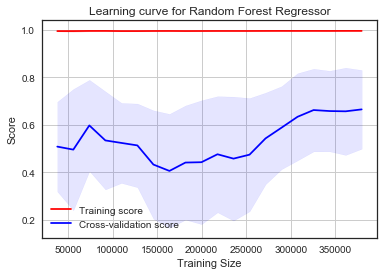

In [72]:
train_size, train_score, test_score = learning_curve(rfr, features, y, cv=10, n_jobs=2, train_sizes=np.linspace(.1, 1.0, 20))

train_mean = np.mean(train_score, axis=1)
train_std  = np.std(train_score, axis=1)
test_mean  = np.mean(test_score, axis=1)
test_std   = np.std(test_score, axis=1)

plt.fill_between(train_size, train_mean-train_std, train_mean+train_std, alpha=0.1, color="r")
plt.fill_between(train_size, test_mean-test_std, test_mean+test_std, alpha=0.1, color="b")

plt.plot(train_size, train_mean, color="r",label="Training score")
plt.plot(train_size, test_mean, color="b",label="Cross-validation score")
         
plt.title("Learning curve for Random Forest Regressor")
plt.ylabel("Score")                
plt.xlabel("Training Size")
plt.grid()
plt.legend(loc="best")

In [36]:
list(zip(columns, rfr.feature_importances_))

[('Store', 0.053878608589078655),
 ('Dept', 0.6311773122692911),
 ('Week', 0.02178070226394319),
 ('Black_Friday', 0.01910816501293905),
 ('Christmas', 0.00841506972280465),
 ('IsHoliday', 0.0006538950821505371),
 ('CPI', 0.02433094607288269),
 ('Unemployment', 0.011431659870416699),
 ('Size', 0.19243115852384185),
 ('Temperature', 0.010528705485371754),
 ('Fuel_Price', 0.005088595243955434),
 ('MarkDown1', 0.0010072224200064295),
 ('MarkDown2', 0.0011241366882508836),
 ('MarkDown3', 0.0025912791424348505),
 ('MarkDown4', 0.0013066495390771974),
 ('MarkDown5', 0.0012730398225405954),
 ('Type_A', 0.00289407723041676),
 ('Type_B', 0.010557136162464495),
 ('Type_C', 0.000421640858133225)]

In [37]:
rfr.get_params().keys()
rfr.score(X_test, y_test)
#help(RandomForestRegressor())

0.9733261445862355

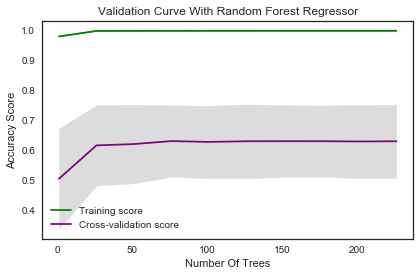

In [36]:
param_range = np.arange(1, 250, 25)
train_scores, test_scores = validation_curve(RandomForestRegressor(), 
                                             features, 
                                             y, 
                                             param_name="n_estimators",
                                             scoring = "r2",
                                             param_range=param_range,
                                             cv=3, 
                                             n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, label="Training score", color="green")
plt.plot(param_range, test_mean, label="Cross-validation score", color="purple")


plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

plt.title("Validation Curve With Random Forest Regressor")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

In [9]:
test_scores

NameError: name 'test_scores' is not defined

### Best Model Selection

Linear models are not recommended to use for given data since they have low validation scores. If compare last three models, Decision Three Regressor gives a bit lower validation score among three models. Also, the model known for its overfitting problem. If compare other two models, both models has approximately same maximized validation scores, however, maximization of validation score cause decrease in training score, which shows that models underfits. If consider Random Forest Regressor, it is clearly overfits, since there is a variance betweent trianing and validation score. Also, it is hard to maximize the score by tuning parameters. To choose a better model, I have constructed graphs comparing 'predicted' vs 'actual' weekly sales for both models

In [42]:
gbr = GradientBoostingRegressor(n_estimators = 150)
y_pred_gbr = gbr.fit(X_train, y_train).predict(X_test)

In [38]:
rfr = RandomForestRegressor(n_estimators = 25)
y_pred_rfr = rfr.fit(X_train, y_train).predict(X_test)

In [41]:
m = walmart_data["IsHoliday"].values
print(y_test, y_pred_rfr)
n = 0
w = 0
for i in range(len(y_test)):
    if m[i] ==1:
        s = 5 * abs(y_test[i] - y_pred_rfr[i])
        n = n + s
        w = w +5
    else:
        s  = abs(y_test[i] - y_pred_rfr[i])
        n = n + s
        w = w + 1
    
print(n)
print(w)
print(n/w)

[  202.76 16482.   48167.29 ...   261.   91894.23 48095.78] [  288.0404 11861.4728 48501.2388 ...   333.4844 90469.4548 50910.2496]
155340036.75440058
108122
1436.710722650345


In [43]:
m = walmart_data["IsHoliday"].values
print(y_test, y_pred_gbr)
n = 0
w = 0
for i in range(len(y_test)):
    if m[i] ==1:
        s = 5 * abs(y_test[i] - y_pred_gbr[i])
        n = n + s
        w = w +5
    else:
        s  = abs(y_test[i] - y_pred_gbr[i])
        n = n + s
        w = w + 1
    
print(n)
print(w)
print(n/w)

[  202.76 16482.   48167.29 ...   261.   91894.23 48095.78] [ 3173.25316347  9492.39539426 40488.83402791 ...  2643.73653069
 73722.77717537 66617.38933557]
672605096.1181611
108122
6220.797766579984


In [28]:
plt.plot(y_test, y_pred_gbr,'ro', color="red")
plt.plot(y_test, y_test,'b-', color ="green")
plt.title("Predicted vs Actual Weekly Sales for Gradient Boosting Regressor")
plt.ylabel("y_pred")                
plt.xlabel("y_test")
plt.show()

plt.plot(y_test, y_pred_rfr,'ro', color="red")
plt.plot(y_test, y_test,'b-', color ="green")
plt.title("Predicted vs Actual Weekly Sales for Random Forest Regressor")
plt.ylabel("y_pred")                
plt.xlabel("y_test")
plt.show()

NameError: name 'y_pred_gbr' is not defined

From the two figures above it is clearly seen that weekly sales predicted by Random Forest Regressor fits the actual weekly sales better that the values predicted by Gradient Boosting Regressor

## Conlusion:
The aim of the project was to identify the most appropriate model for predicting weekly sales for Walmart stores using the machine learning tools and techniques, and python library. Since the project was on unsupervised learning, I used regression models for value prediction. In total, five regression models were considered. Decision Tree Regressor, Gradient Boosying Regressor, and Random Forest Regressor models found out to have lower out-of-sample errors, one of them having underfittiing, and other overfitting issue to some extent. It was hard to identify the model with a better bias-variance tradeoff. Therefore, predicted weekly sales for unseen data were compared with actual data for both models, and it was concluded that Random Forest Regressor is more appropriate model for Walmart weekly sales prediction. This was an interesting, and challenging project, and the best outcome I could achieve was about 67 percent accuracy. In my opinion, for large store sales such as Walmart it is hard to achieve high validation scores, because a lot of things in market depends on human behavior (their taste), change in people's income, as well as opening of new stores of other brands nearby, selling the same products, or their closure. It is possible to make overall inferences about key factors that affect sales, such as size of the store, or type of the department as was discussed in the project. In the future, it could be achieve more precise results, if there will be more information about customers, and other stores nearby.